<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Oil_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the required libraries

In [96]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

# Importing the required packages

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [98]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


# Dates for which data will be extracted

In [99]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [100]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

# Get OPEC Oil price data for Nasdaq

In [101]:

OilPriceInUSD=getDataFromAPI("Nasdaq","OPEC/ORB",FirstDay,CurrentDate).reset_index()
OilPriceInUSD['Date'] = pd.to_datetime(OilPriceInUSD['Date']).dt.date
OilPriceInUSD.set_index('Date', inplace=True)
OilPriceInUSD

OilPriceInUSD=OilPriceInUSD.asfreq('b')
OilPriceInUSD['Original_Oil_Price']=OilPriceInUSD.Value.fillna(method='bfill')
df_Oil_InUSD=OilPriceInUSD[['Original_Oil_Price']]
df_Oil_InUSD

,Original_Oil_Price
Date,
2020-06-01,33.69
2020-06-02,34.96
2020-06-03,35.47
2020-06-04,34.85
2020-06-05,36.84
...,...
2023-06-30,76.14
2023-07-03,76.12
2023-07-04,76.18


In [102]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]

    # Print the results
    print("Augmented Dickey-Fuller Test:")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # Check the p-value against a significance level (e.g., 0.05) to determine stationarity
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")



# Finding optimal values of p,d,q for ARIMA

## *   **AR term (p)**
This are lags of dependent variables. e.g. predictors for x(t) is x
(t-1) + x(t-2) + x(t-3).

## *   **Differentiation (d)**
This are number of occasions where we apply differentiation.

## *   **MA term (q)**
This are lags for errors in prediction e.g. predictor for x(t) is e(t-1) + e(t-2) + e(t-3), where e(i) is the difference between the moving average value and the actual value.




#Check if data is stationary by doing differnce

In [103]:
perform_adfuller(OilPriceInUSD['Original_Oil_Price'].diff(1).dropna())

Augmented Dickey-Fuller Test:
Test Statistic: -6.254351076061134
P-value: 4.3757525351732236e-08
The time series is stationary.


In [104]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def plot_acf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(data.dropna(), lags=lags, ax=ax,zero=False)
    plt.title('ACF')
    plt.show()

def plot_pacf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_pacf(data.dropna(), lags=lags, ax=ax,zero=False,alpha=0.05)
    plt.title('PACF')
    plt.show()


# Verifying the lags which can be selected for Training the model

#The lag value where the chart crosses the confidence interval for the first time can be good starting to point to select values of P(ACF) and Q(PACF)

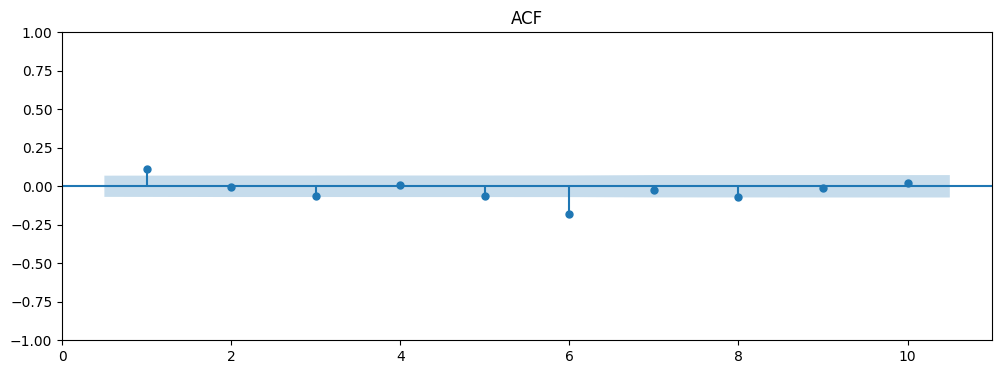

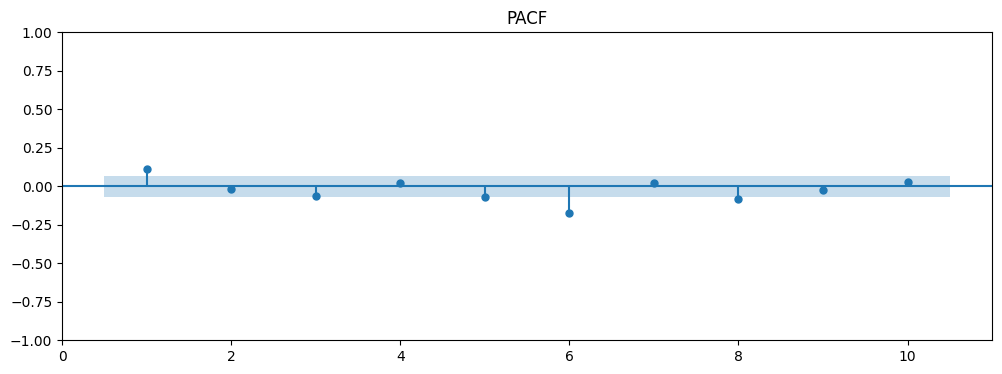

In [105]:
plot_acf_values(OilPriceInUSD['Original_Oil_Price'].diff(1),10)
plot_pacf_values(OilPriceInUSD['Original_Oil_Price'].diff(1),10)

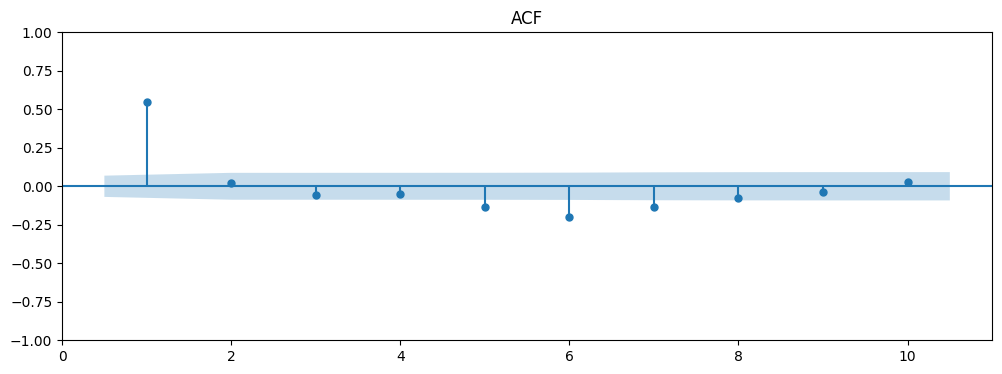

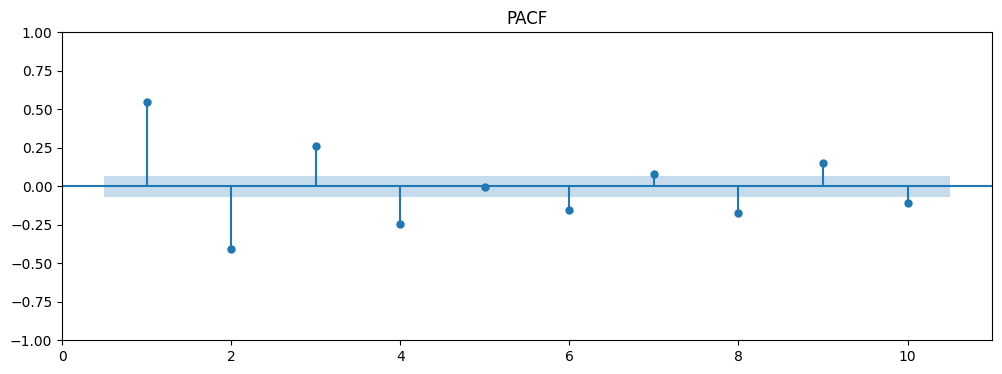

In [106]:
plot_acf_values(OilPriceInUSD['Original_Oil_Price'].diff(2),10)
plot_pacf_values(OilPriceInUSD['Original_Oil_Price'].diff(2),10)

# Defining Training and Testing timeline

In [107]:
# Define the start and end dates for train and test data
train_start_date = pd.to_datetime(FirstDay)
train_end_date = pd.to_datetime('2022-12-31')
test_start_date = pd.to_datetime('2023-01-01')


In [108]:
train_data_oil = df_Oil_InUSD[(df_Oil_InUSD.index >= train_start_date) & (df_Oil_InUSD.index <= train_end_date)]
test_data_oil = df_Oil_InUSD[df_Oil_InUSD.index >= test_start_date]
train_data_oil.head(5)



,Original_Oil_Price
Date,
2020-06-01,33.69
2020-06-02,34.96
2020-06-03,35.47
2020-06-04,34.85
2020-06-05,36.84


# Auto Arima to find values of p,d,q

In [109]:
from pmdarima import auto_arima
model = auto_arima(train_data_oil['Original_Oil_Price'].dropna(),
                   start_p=1, max_p=5, start_q=1, max_q=5, start_d=2,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
model.summary()


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2701.542, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2694.657, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2696.411, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2693.857, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2695.821, Time=0.22 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2697.036, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2694.573, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2696.545, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2697.598, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2691.574, Time=0.39 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2693.429, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2696.513, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2691.710, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2683.627, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2693.171, Time=0.54 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  675
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1335.814
Date:                Mon, 10 Jul 2023   AIC                           2683.627
Time:                        08:55:05   BIC                           2710.707
Sample:                    06-01-2020   HQIC                          2694.113
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2132      0.221      0.963      0.336      -0.221       0.647
ar.L1         -1.2387      0.043    -29.043      0.000      -1.322      -1.155
ar.L2         -0.7832      0.041    -19.093      0.000      -0.864      -0.703
ma.L1          1.3150      0.034     38.323      0.000       1.248       1.382
ma.L2          0.9058      0.035     25.889      0.000       0.837       0.974
sigma2         3.0812      0.096     32.187      0.000       2.894       3.269
===================================================================================
Ljung-Box (L1) (Q):                   2.18   Jarque-Bera (JB):              1337.33
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               7.87   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
import warnings
warnings.filterwarnings("ignore")


#After verifying manually diffrent values , along with what was observed from plot_acf and plot_pacf decided values of p,d,q

In [111]:
from statsmodels.tsa.arima.model import ARIMA

oil_model=ARIMA(train_data_oil['Original_Oil_Price'],order=(4,1,2))
oil_model_fit=oil_model.fit()
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Original_Oil_Price   No. Observations:                  675
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1337.921
Date:                Mon, 10 Jul 2023   AIC                           2689.842
Time:                        08:55:06   BIC                           2721.434
Sample:                    06-01-2020   HQIC                          2702.075
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0959      0.096     -1.002      0.316      -0.283       0.092
ar.L2          0.7239      0.102      7.101      0.000       0.524       0.924
ar.L3         -0.1310      0.022     -5.944      0.000      -0.174      -0.088
ar.L4         -0.0923      0.035     -2.667      0.008      -0.160      -0.024
ma.L1          0.2069      0.096      2.152      0.031       0.018       0.395
ma.L2         -0.7153      0.109     -6.551      0.000      -0.929      -0.501
sigma2         3.1018      0.086     36.267      0.000       2.934       3.269
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2489.90
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.00   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
from statsmodels.tsa.arima.model import ARIMA

oil_model=ARIMA(train_data_oil['Original_Oil_Price'],order=(4,1,2))
oil_model_fit=oil_model.fit()
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Original_Oil_Price   No. Observations:                  675
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1337.921
Date:                Mon, 10 Jul 2023   AIC                           2689.842
Time:                        08:55:06   BIC                           2721.434
Sample:                    06-01-2020   HQIC                          2702.075
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0959      0.096     -1.002      0.316      -0.283       0.092
ar.L2          0.7239      0.102      7.101      0.000       0.524       0.924
ar.L3         -0.1310      0.022     -5.944      0.000      -0.174      -0.088
ar.L4         -0.0923      0.035     -2.667      0.008      -0.160      -0.024
ma.L1          0.2069      0.096      2.152      0.031       0.018       0.395
ma.L2         -0.7153      0.109     -6.551      0.000      -0.929      -0.501
sigma2         3.1018      0.086     36.267      0.000       2.934       3.269
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2489.90
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.00   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Things to verifiy in optimal model selection
### 1) Log Likelihood ==> Higher the log value better the model is performing.
### 2) AIC , BIC, HQIC --> This are information criteria whcih states lower the criteria better is the model.

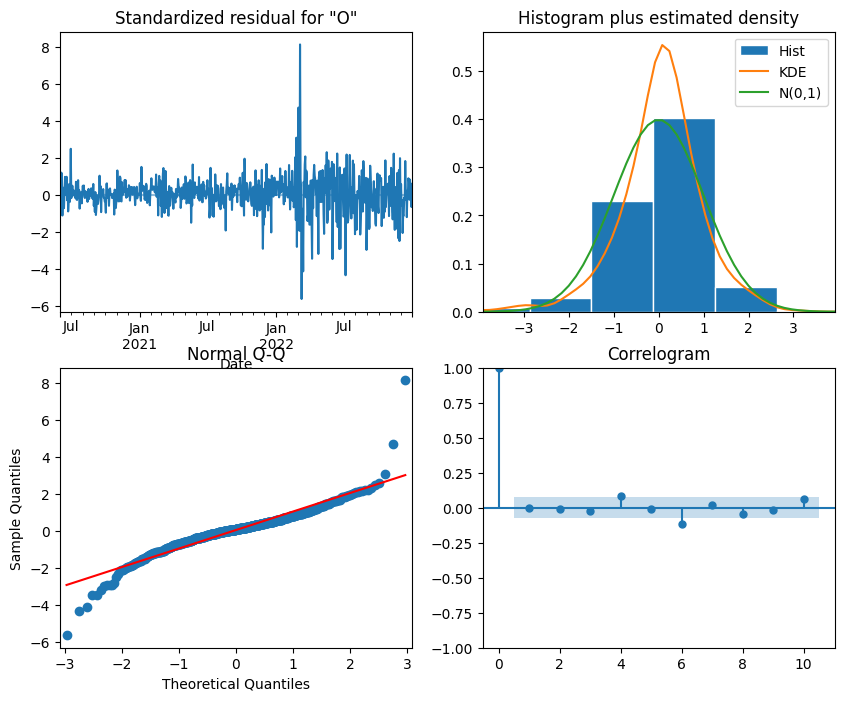

In [113]:
oil_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


### **1. Standardized Residulal** : This residual doesnt show any pattern and are randomly distributed around zero.
### **2. Histogram Plust esitmeted density** : Residuals are normally distriuted
### **3. Normal Q-Q Plot** : Most of the are along red line
### **4. Correlogram** : Its and ACF plot of residuals at diffrent lag and their is no autocorrelation seen

In [114]:
# Get in-sample predictions
training_data_predictions = oil_model_fit.get_prediction(start=train_data_oil.dropna().index.min(),
                                                      end=train_data_oil.dropna().index.max(),
                                                      dynamic=False)

train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_oil['Oil predictions'] = training_data_predictions.predicted_mean

train_data_oil

,Original_Oil_Price,lower Oil predictions,Higher Oil predictions,Oil predictions
Date,,,,
2020-06-01,33.69,-1959.967128,1959.967128,0.000000
2020-06-02,34.96,30.179532,37.200493,33.690013
2020-06-03,35.47,31.620674,38.594172,35.107423
2020-06-04,34.85,32.032661,39.005925,35.519293
2020-06-05,36.84,31.221881,38.183116,34.702499
...,...,...,...,...
2022-12-26,82.23,77.319568,84.223267,80.771417
2022-12-27,82.23,78.498689,85.402387,81.950538
2022-12-28,81.96,78.896077,85.799775,82.347926


In [115]:
forecast = oil_model_fit.get_forecast(steps=5, alpha=0.05)
forecast.predicted_mean

2023-01-02    81.144985
2023-01-03    81.284243
2023-01-04    81.192909
2023-01-05    81.238400
2023-01-06    81.163063
Freq: B, Name: predicted_mean, dtype: float64

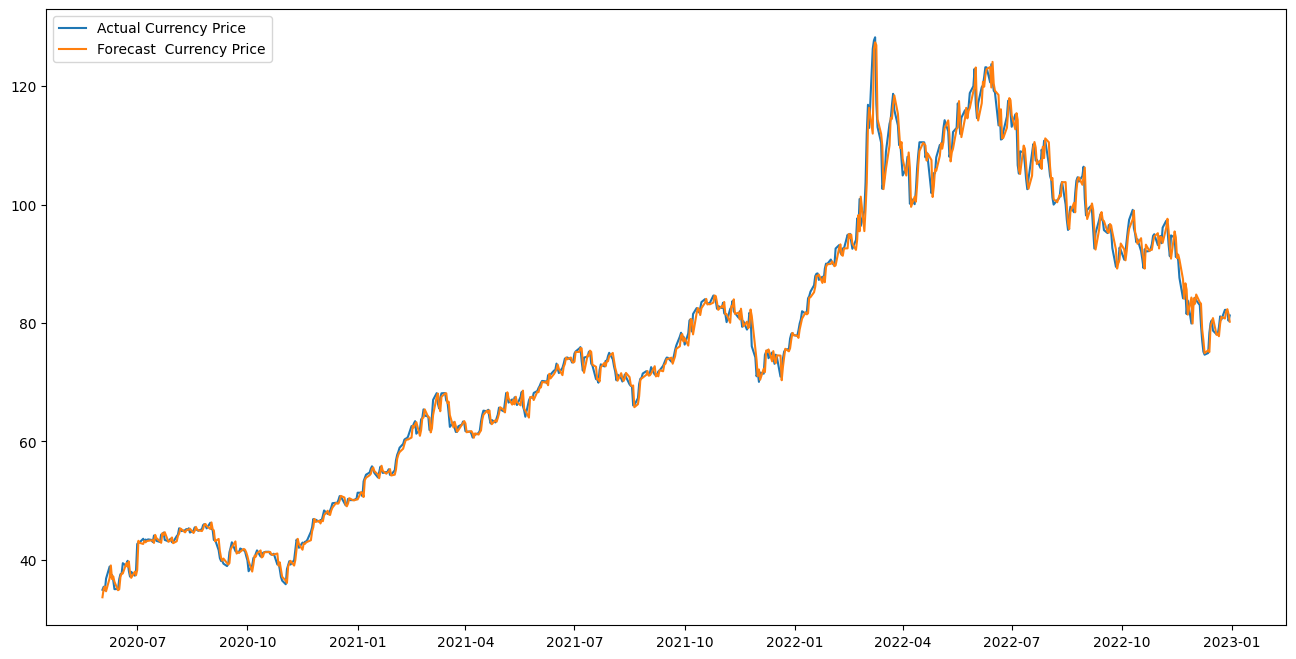

In [116]:
plt.figure(figsize=(16,8))
plt.plot(train_data_oil['Original_Oil_Price'][1:],label="Actual Currency Price")
plt.plot(train_data_oil['Oil predictions'][1:],label="Forecast  Currency Price")
plt.legend(loc="upper left")

# One Day Steap Ahead -Walk-Forward Validation



In [125]:
import pandas as pd

# define train test data
train = train_data_oil['Original_Oil_Price'].dropna()
test = test_data_oil['Original_Oil_Price'].dropna()

# define model configuration
my_order = (4,1,2)

# lists to collect forecasts
forecasts = []
forecast_dates = []

# walk-forward validation
history = [x for x in train]
for i in range(len(test)):

    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
    #my_order = auto.order
    model = ARIMA(history, order=my_order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    forecast_dates.append(test.index[i])
    history.append(forecast.predicted_mean[0])

    print("my_order is {} for date {} and predicted value is {} and actual value is {} ".format(my_order,test.index[i],forecast.predicted_mean[0],test[test.index[i]]))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=forecast_dates)



my_order is (4, 1, 2) for date 2023-01-02 00:00:00 and predicted value is 81.14498467913181 and actual value is 82.05 
my_order is (4, 1, 2) for date 2023-01-03 00:00:00 and predicted value is 81.28425868873893 and actual value is 82.05 
my_order is (4, 1, 2) for date 2023-01-04 00:00:00 and predicted value is 81.19291499694867 and actual value is 76.88 
my_order is (4, 1, 2) for date 2023-01-05 00:00:00 and predicted value is 81.23841562892895 and actual value is 75.77 
my_order is (4, 1, 2) for date 2023-01-06 00:00:00 and predicted value is 81.16304177031674 and actual value is 76.15 
my_order is (4, 1, 2) for date 2023-01-09 00:00:00 and predicted value is 81.20228235037898 and actual value is 77.57 
my_order is (4, 1, 2) for date 2023-01-10 00:00:00 and predicted value is 81.14641753127272 and actual value is 77.0 
my_order is (4, 1, 2) for date 2023-01-11 00:00:00 and predicted value is 81.18588910187025 and actual value is 78.23 
my_order is (4, 1, 2) for date 2023-01-12 00:00:0

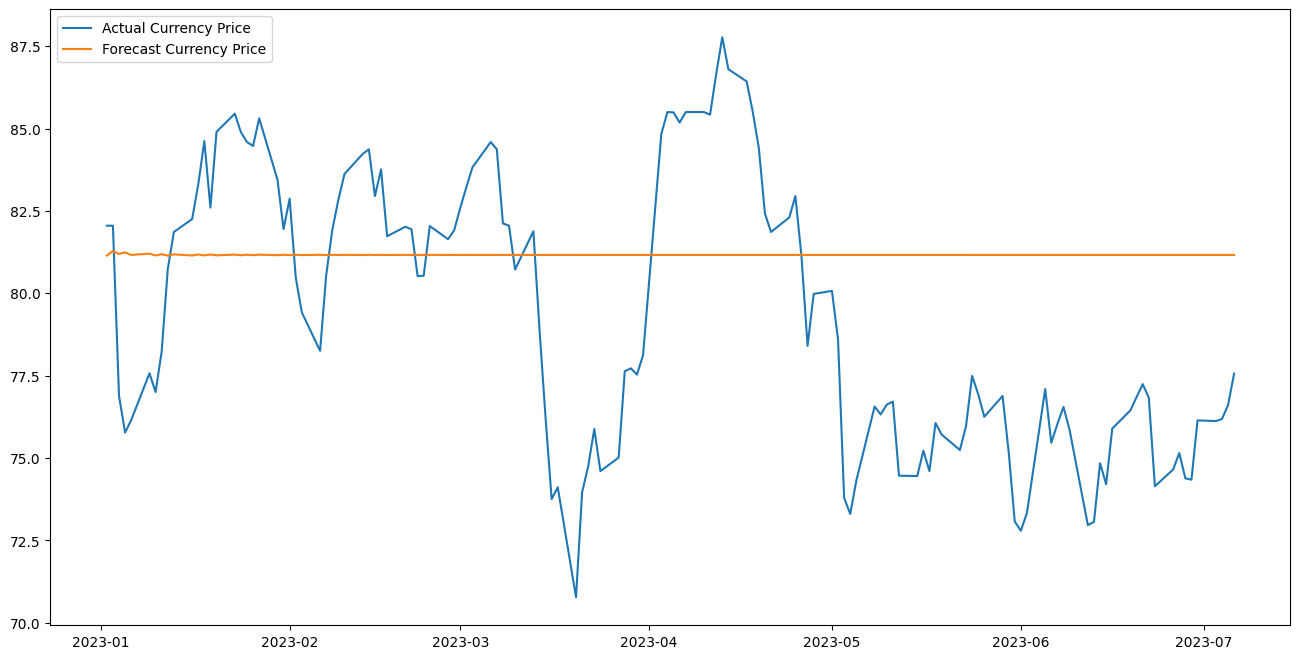

In [118]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}




# Calcualate metrics of model for One Day Forecasting

In [120]:


metrics = calculate_metrics(test_data_oil['Original_Oil_Price'], forecast_df['Forecast'])
metrics

{'Mean Absolute Error': 3.9199178420512366,
 'Mean Squared Error': 20.466126682175425,
 'Root Mean Squared Error': 4.523950340374596,
 'Mean Absolute Percentage Error': 5.0540723130446}

# Five Day Steap Ahead -Walk-Forward Validation



In [133]:
import pandas as pd

# define train test data
train = train_data_oil['Original_Oil_Price'].dropna()
test = test_data_oil['Original_Oil_Price'].dropna()

# define model configuration
my_order = (4,1,2)

# lists to collect forecasts
forecasts = []
forecast_dates = []

# walk-forward validation
history = [x for x in train]
for i in range(0, len(test), 5):  # now stepping by 5
    # Commenting below lines a model not predicting any new model , so used the value found earlier
    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
    #my_order = auto.order

    model = ARIMA(history, order=my_order)
    model_fit = model.fit()

    # if less than 5 steps remaining, adjust steps to fit
    steps = min(5, len(test) - i)

    forecast = model_fit.get_forecast(steps=steps, alpha=0.05)

    forecasts.extend(forecast.predicted_mean)  # using extend instead of append
    forecast_dates.extend(test.index[i:i+steps])  # storing dates for all 5 days

    # Append all forecasted values to the history
    history.extend(forecast.predicted_mean)
    print("my_order is {} for Week Starting {} and predicted value is {} and actual value is {}".format(my_order,test.index[i],forecast.predicted_mean,test[test.index[i:i+steps]].values.tolist()))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=forecast_dates)


my_order is (4, 1, 2) for Week Starting 2023-01-02 00:00:00 and predicted value is [81.14498468 81.2842433  81.19290942 81.23839975 81.16306259] and actual value is [82.05, 82.05, 76.88, 75.77, 76.15]
my_order is (4, 1, 2) for Week Starting 2023-01-09 00:00:00 and predicted value is [81.20237781 81.14650542 81.18599362 81.14356585 81.17990988] and actual value is [77.57, 77.0, 78.23, 80.73, 81.86]
my_order is (4, 1, 2) for Week Starting 2023-01-16 00:00:00 and predicted value is [81.14572278 81.17720267 81.14859228 81.1752469  81.15101254] and actual value is [82.25, 83.3, 84.62, 82.6, 84.9]
my_order is (4, 1, 2) for Week Starting 2023-01-23 00:00:00 and predicted value is [81.17350875 81.15293122 81.17190337 81.15447835 81.17050199] and actual value is [85.45, 84.89, 84.59, 84.47, 85.31]
my_order is (4, 1, 2) for Week Starting 2023-01-30 00:00:00 and predicted value is [81.15575255 81.16930764 81.15684013 81.16830121 81.15776277] and actual value is [83.45, 81.95, 82.87, 80.48, 79.42]

# Calcualate metrics of model for Five  Day Forecasting

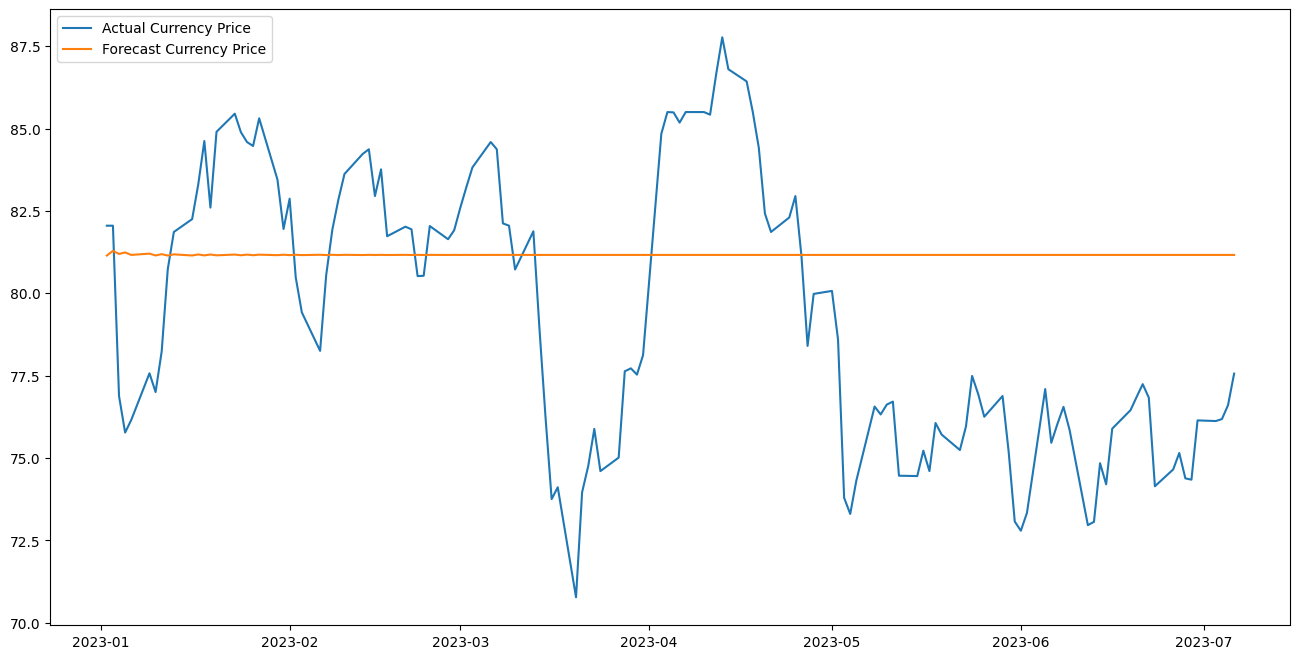

In [134]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [135]:


metrics = calculate_metrics(test_data_oil['Original_Oil_Price'], forecast_df['Forecast'])
metrics

{'Mean Absolute Error': 3.9199264734286605,
 'Mean Squared Error': 20.466228005818454,
 'Root Mean Squared Error': 4.523961538941114,
 'Mean Absolute Percentage Error': 5.054084331337654}